# Binarization

In [67]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

@cuda.jit(nopython=True)
def binarization(x):
  threshold = 20
  if x < threshold:
    return 0
  return 1

@cuda.jit
def grayscale(src, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = binarization(g)


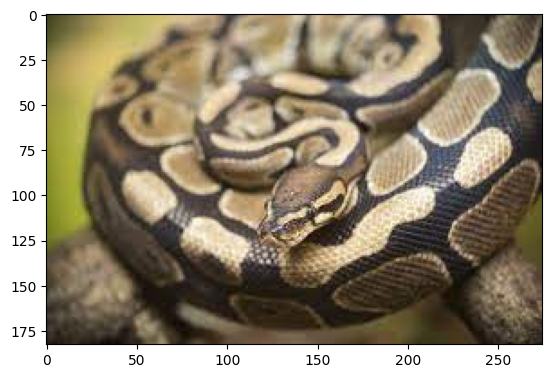

In [68]:
rgb_image = imread('python.jpg')
plt.imshow(rgb_image)

In [69]:
rgb_image.shape

(183, 275, 3)

# GPU 1D

In [70]:
# Load an RGB image
rgb_image = imread('python.jpg')

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

In [71]:
rgb_flat_1 = rgb_image.reshape(pixel_count, 3)
rgb_flat_1.shape

(50325, 3)

In [72]:
blocks = [2,4,8,16,32,64,128,256,512]
times = []

In [73]:
# for b in blocks:
#   start_time_gpu = time.time()
#   devSrc = cuda.to_device(rgb_flat_1)
#   devDst = cuda.device_array((pixel_count, 3), np.uint8)
#   grayscale[gridSize, b](devSrc, devDst)
#   hostDst = devDst.copy_to_host()
#   gpu_time = time.time() - start_time_gpu
#   times.append(gpu_time)

In [74]:
start_time_gpu = time.time()
devSrc = cuda.to_device(rgb_flat_1)
devDst = cuda.device_array((pixel_count, 3), np.uint8)
grayscale[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [75]:
new_image = hostDst.reshape(imageWidth, imageHeight, 3)

In [76]:
new_image.shape

(183, 275, 3)

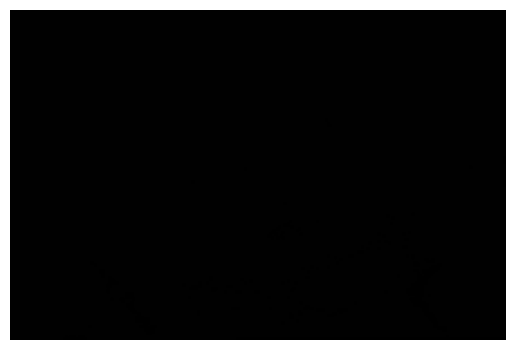

In [77]:
plt.imshow(new_image)
plt.axis('off')
plt.show()

In [78]:
# new_image

In [51]:
times

[0.16770291328430176,
 0.0013709068298339844,
 0.0007872581481933594,
 0.0010595321655273438,
 0.0006928443908691406,
 0.0006773471832275391,
 0.0006749629974365234,
 0.0007011890411376953,
 0.0007548332214355469]

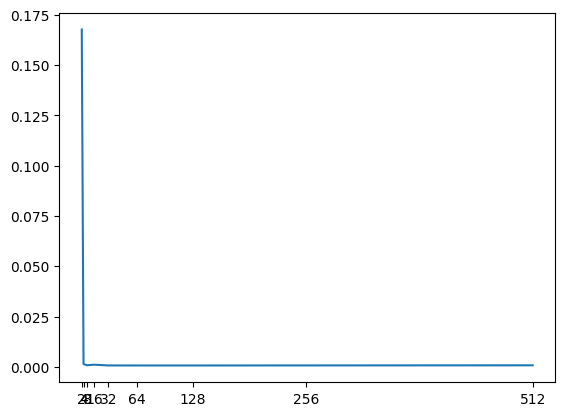

In [52]:
plt.plot(blocks, times)
plt.xticks(blocks)
plt.show()

# Brightness control

In [91]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

@cuda.jit(nopython=True)
def brightness(x, amount):
  if x + amount > 255:
    return 255
  elif x + amount < 0:
    return 0
  return x + amount

@cuda.jit
def brightness_change(src, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8(((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3))

    dst[tidx, 0] = brightness(np.uint8(src[tidx, 0]), 50)
    dst[tidx, 1] = brightness(np.uint8(src[tidx, 1]), 50)
    dst[tidx, 2] = brightness(np.uint8(src[tidx, 2]), 50)


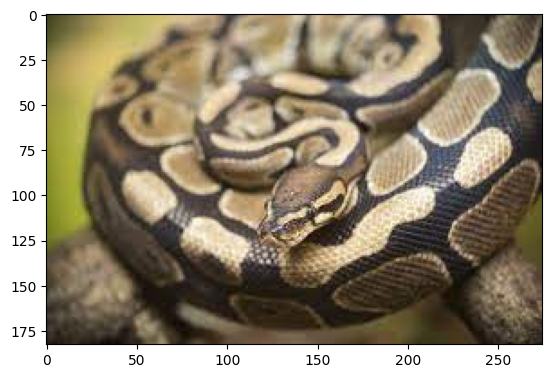

In [92]:
rgb_image = imread('python.jpg')
plt.imshow(rgb_image)

In [93]:
# Load an RGB image
rgb_image = imread('python.jpg')

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

In [94]:
rgb_flat_1 = rgb_image.reshape(pixel_count, 3)
rgb_flat_1.shape

(50325, 3)

In [95]:
start_time_gpu = time.time()
devSrc = cuda.to_device(rgb_flat_1)
devDst = cuda.device_array((pixel_count, 3), np.uint8)
brightness_change[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [96]:
new_image = hostDst.reshape(imageWidth, imageHeight, 3)

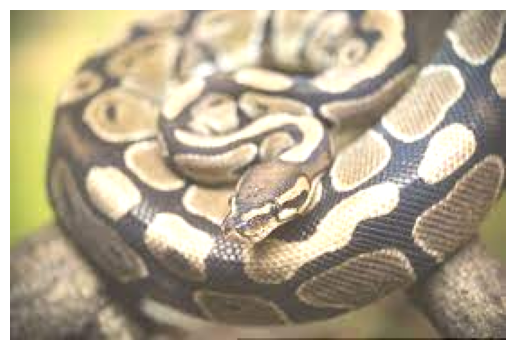

In [97]:
plt.imshow(new_image)
plt.axis('off')
plt.show()

# Blending images

In [189]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

@cuda.jit(nopython=True)
def blending(x, y):
  return np.uint8(0.2*x + 0.8*y)
  # return np.uint8(x)

@cuda.jit
def blending_image(src1, src2, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    dst[tidx, 0] = blending(src1[tidx, 0], src2[tidx, 0])
    dst[tidx, 1] = blending(src1[tidx, 1], src2[tidx, 1])
    dst[tidx, 2] = blending(src1[tidx, 2], src2[tidx, 2])


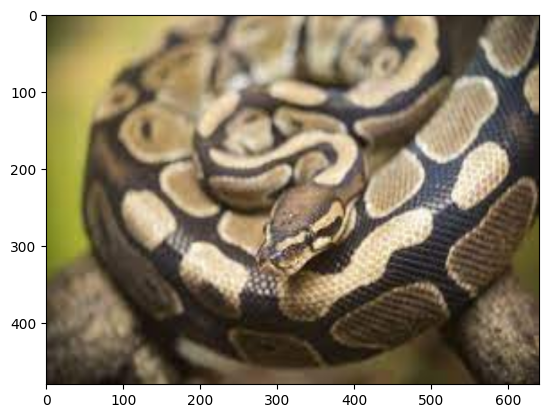

In [190]:
import numpy as np
import cv2
rgb_image1 = imread('python.jpg')

new_width, new_height = 640, 480

resized_image1 = cv2.resize(rgb_image1, (new_width, new_height))

plt.imshow(resized_image1)

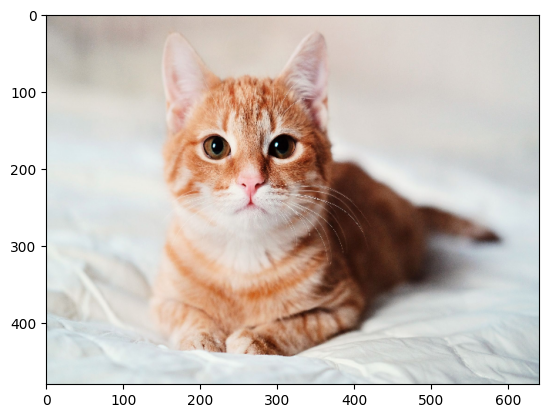

In [191]:
import numpy as np
import cv2
rgb_image2 = imread('beautiful.jpg')

new_width, new_height = 640, 480

resized_image2 = cv2.resize(rgb_image2, (new_width, new_height))

plt.imshow(resized_image2)

In [192]:
# Load an RGB image
# rgb_image = imread('python.jpg')

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight = resized_image2.shape[0], resized_image2.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

In [193]:
rgb_flat_1 = resized_image1.reshape(pixel_count, 3)
rgb_flat_2 = resized_image2.reshape(pixel_count, 3)

In [194]:
start_time_gpu = time.time()
devSrc1 = cuda.to_device(rgb_flat_1)
devSrc2 = cuda.to_device(rgb_flat_2)
devDst = cuda.device_array((pixel_count, 3), np.uint8)
blending_image[gridSize, blockSize](devSrc1, devSrc2, devDst)
hostDst = devDst.copy_to_host()
gpu_time = time.time() - start_time_gpu

In [195]:
new_image = hostDst.reshape(imageWidth, imageHeight, 3)

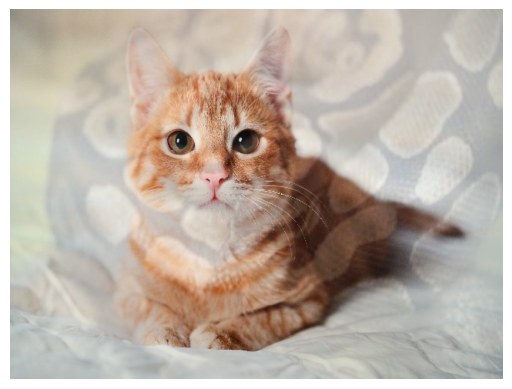

In [196]:
plt.imshow(new_image)
plt.axis('off')
plt.show()

# GPU 2D

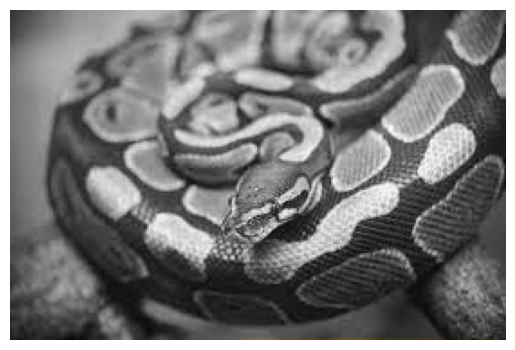

In [53]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

# Define a Numba CUDA kernel for grayscale conversion
@cuda.jit
def grayscale(src, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

rgb_image = imread('python.jpg')
plt.imshow(rgb_image)

# Load an RGB image
rgb_image = imread('python.jpg')

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
blockSize = 1024
gridSize = int(pixel_count / blockSize)

rgb_flat_1 = rgb_image.reshape(pixel_count, 3)
rgb_flat_1.shape

devSrc = cuda.to_device(rgb_flat_1)
devDst = cuda.device_array((pixel_count, 3), np.uint8)
grayscale[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()

new_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image)
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 54 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


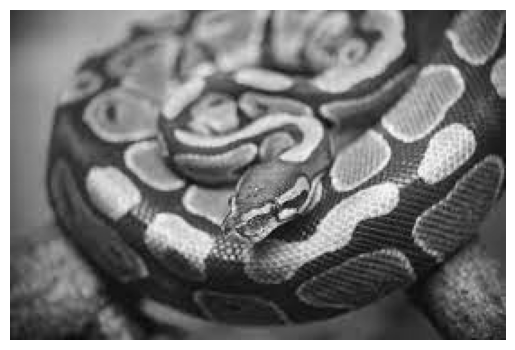

In [55]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import time

# Define a Numba CUDA kernel for grayscale conversion
@cuda.jit
def grayscale(src, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    g = np.uint8((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
    dst[tidx, tidy, 0] = dst[tidx, tidy, 1] = dst[tidx, tidy, 2] = g

# @cuda.jit
# def grayscale(src, dst):
#     # where are we in the input?
#     tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

#     g = np.uint8((src[tidy, tidx, 0] + src[tidy, tidx, 1] + src[tidy, tidx, 2]) / 3)
#     dst[tidy, tidx, 0] = dst[tidy, tidx, 1] = dst[tidy, tidx, 2] = g

# rgb_image = imread('python.jpg')
# plt.imshow(rgb_image)

# Load an RGB image
rgb_image = imread('python.jpg')

# Flatten the image into a 1D array of RGB
imageWidth, imageHeight  = rgb_image.shape[0], rgb_image.shape[1]
pixel_count = imageWidth * imageHeight
# blockSize = 1024
# gridSize = int(pixel_count / blockSize)

gridSize = (8, 8)
blockSize = (32, 32)

blockDim = (32, 32)
gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

# rgb_flat_1 = rgb_image.reshape(pixel_count, 3)
# rgb_flat_1.shape

devSrc = cuda.to_device(rgb_image)
devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)
# grayscale[gridSize, blockSize](devSrc, devDst)
grayscale[gridDim, blockDim](devSrc, devDst)
hostDst = devDst.copy_to_host()

new_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image)
plt.axis('off')
plt.show()

# why does 32 gave weird image
# 64 give not fully grayscale
# this must be a rectangular

In [56]:
blockDim

(32, 32)

In [57]:
gridDim

(6, 9)

In [58]:
(imageWidth, imageHeight)

(183, 275)

In [59]:
blockS = [(2,2), (4,4), (8,8), (16,16), (32, 32)]
timeS = []

In [60]:
for b in blockS:

  start_time_gpu = time.time()
  blockDim = b
  gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

  # rgb_flat_1 = rgb_image.reshape(pixel_count, 3)
  # rgb_flat_1.shape

  devSrc = cuda.to_device(rgb_image)
  devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)
  # grayscale[gridSize, blockSize](devSrc, devDst)
  grayscale[gridDim, blockDim](devSrc, devDst)
  hostDst = devDst.copy_to_host()

  new_image = hostDst.reshape(imageWidth, imageHeight, 3)
  gpu_time = time.time() - start_time_gpu
  timeS.append(gpu_time)

In [61]:
timeS

[0.0038404464721679688,
 0.0016369819641113281,
 0.0010173320770263672,
 0.0011343955993652344,
 0.0014586448669433594]

In [62]:
# blockS1 = [2, 4, 8, 16, 32]
# plt.plot(blockS1, timeS)
# plt.xticks(blockS1)
# plt.show()

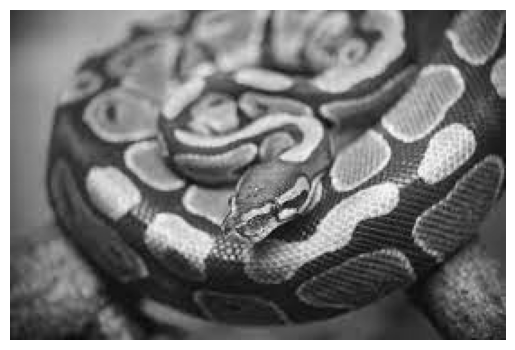

In [63]:
plt.imshow(new_image)
plt.axis('off')
plt.show()

# Without shared memory

In [64]:
filter = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
])

In [65]:
# import numpy as np

# matrix =
# [[0, 0, 1, 2, 1, 0, 0],
#   [0, 3, 13, 22, 13, 3, 0],
#   [1, 13, 59, 97, 59, 13, 1],
#   [2, 22, 97, 159, 97, 22, 2],
#   [1, 13, 59, 97, 59, 13, 1],
#   [0, 3, 13, 22, 13, 3, 0],
#   [0, 0, 1, 2, 1, 0, 0]]


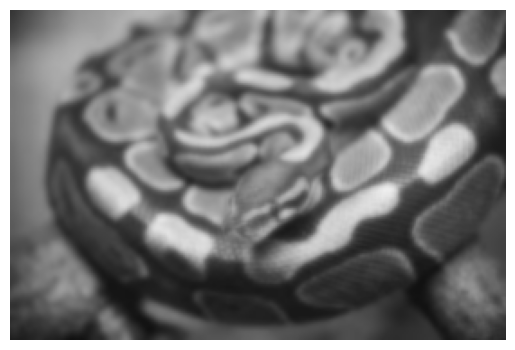

In [66]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Define a Numba CUDA kernel for grayscale with Gaussian blur filter
@cuda.jit
def grayscale_with_blur(src, dst):
    tidx, tidy = cuda.grid(2)

    if tidx < src.shape[0] and tidy < src.shape[1]:
        total_weight = 0.0
        weighted_sum = 0.0
        for i in range(-3, 4):
            for j in range(-3, 4):
                if (tidx + i) >= 0 and (tidx + i) < src.shape[0] and (tidy + j) >= 0 and (tidy + j) < src.shape[1]:
                    pixel_value = (src[tidx + i, tidy + j, 0] + src[tidx + i, tidy + j, 1] + src[tidx + i, tidy + j, 2]) / 3
                    weight = gaussian_filter[i + 3][j + 3]
                    weighted_sum += pixel_value * weight
                    total_weight += weight
        dst[tidx, tidy, 0] = dst[tidx, tidy, 1] = dst[tidx, tidy, 2] = np.uint8(weighted_sum / total_weight)

# Define a 7x7 Gaussian filter
gaussian_filter = np.array([
    [1, 1, 2, 2, 2, 1, 1],
    [1, 2, 2, 4, 2, 2, 1],
    [2, 2, 4, 8, 4, 2, 2],
    [2, 4, 8, 16, 8, 4, 2],
    [2, 2, 4, 8, 4, 2, 2],
    [1, 2, 2, 4, 2, 2, 1],
    [1, 1, 2, 2, 2, 1, 1]
])

rgb_image = imread('python.jpg')
plt.imshow(rgb_image)

# Load an RGB image
rgb_image = imread('python.jpg')

imageWidth, imageHeight  = rgb_image.shape[0], rgb_image.shape[1]

blockDim = (16, 16)
gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

devSrc = cuda.to_device(rgb_image)
devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

# Launch the kernel with the 2D grid and block configuration
grayscale_with_blur[gridDim, blockDim](devSrc, devDst)
hostDst = devDst.copy_to_host()

new_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image)
plt.axis('off')
plt.show()


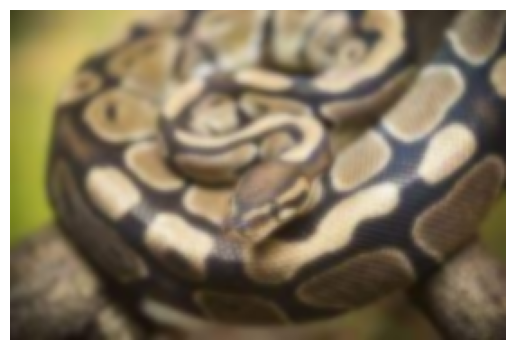

In [67]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread

@cuda.jit
def gaussian_blur(src, dst):
    tidx, tidy = cuda.grid(2)

    if tidx < src.shape[0] and tidy < src.shape[1]: # because this will run though each pixel so don't need to restart
    # tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    # tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
        total_weight = 0.0
        weighted_sum_r = 0.0
        weighted_sum_g = 0.0
        weighted_sum_b = 0.0
        for i in range(-3, 4):
            for j in range(-3, 4):
                if (tidx + i) >= 0 and (tidx + i) < src.shape[0] and (tidy + j) >= 0 and (tidy + j) < src.shape[1]:
                    pixel_r = src[tidx + i, tidy + j, 0]
                    pixel_g = src[tidx + i, tidy + j, 1]
                    pixel_b = src[tidx + i, tidy + j, 2]
                    weight = gaussian_filter[i + 3][j + 3]
                    weighted_sum_r += pixel_r * weight
                    weighted_sum_g += pixel_g * weight
                    weighted_sum_b += pixel_b * weight
                    total_weight += weight
        dst[tidx, tidy, 0] = np.uint8(weighted_sum_r / total_weight)
        dst[tidx, tidy, 1] = np.uint8(weighted_sum_g / total_weight)
        dst[tidx, tidy, 2] = np.uint8(weighted_sum_b / total_weight)

# Define a 7x7 Gaussian filter
gaussian_filter = np.array([
    [1, 1, 2, 2, 2, 1, 1],
    [1, 2, 2, 4, 2, 2, 1],
    [2, 2, 4, 8, 4, 2, 2],
    [2, 4, 8, 16, 8, 4, 2],
    [2, 2, 4, 8, 4, 2, 2],
    [1, 2, 2, 4, 2, 2, 1],
    [1, 1, 2, 2, 2, 1, 1]
])

# Load an RGB image
rgb_image = imread('python.jpg')

# Get the image dimensions
imageWidth, imageHeight  = rgb_image.shape[0], rgb_image.shape[1]

# Create a grid and block configuration
blockDim = (16, 16)
gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

devSrc = cuda.to_device(rgb_image)
devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

# Launch the kernel with the 2D grid and block configuration
gaussian_blur[gridDim, blockDim](devSrc, devDst)
hostDst = devDst.copy_to_host()

new_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image)
plt.axis('off')
plt.show()


In [86]:
block_not_shared = [(2,2), (2,2), (4,4), (8,8), (16,16), (32, 32)]
time_not_shared = []

time_not_shared_avg = []

for i in range(100):
  time_T = 0
  for b in block_not_shared:

    start_time_gpu = time.time()
    blockDim = b
    gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

    devSrc = cuda.to_device(rgb_image)
    devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

    # Launch the kernel with the 2D grid and block configuration
    gaussian_blur[gridDim, blockDim](devSrc, devDst)
    hostDst = devDst.copy_to_host()

    new_image = hostDst.reshape(imageWidth, imageHeight, 3)
    gpu_time = time.time() - start_time_gpu
    time_not_shared.append(gpu_time)

    if i == 0:
      time_not_shared_avg.append(gpu_time)
    else:
      time_not_shared_avg[time_T] = time_not_shared_avg[time_T] + time_not_shared[time_T]
    time_T += 1

block_not_shared1 = [2, 4, 8, 16, 32]

In [87]:
for t in time_not_shared_avg:
  print(t/100)

0.012189626693725586
0.005288124084472656
0.0038025379180908203
0.0016033649444580078
0.0016756057739257812
0.0019257068634033203


In [81]:
np.average(time_not_shared[1:])

0.0036536216735839843

In [70]:
# plt.plot(block_not_shared1, time_not_shared)
# plt.xticks(block_not_shared1)
# plt.show()

# Shared memory

In [71]:
# tile = cuda.shared.array((cuda.blockDim.x, cuda.blockDim.y),numba.uint8)
# tidx = ...
# tidy = ...
# tile[cuda.threadIdx.x, cuda.threadIdx.y] = src[tidx, tidy, 0]

In [72]:
# import numpy as np
# import numba
# from numba import cuda
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

# # Define a Numba CUDA kernel for Gaussian blur with shared memory
# @cuda.jit
# def gaussian_blur_shared(src, dst, filter):
#     tidx, tidy = cuda.grid(2)

#     if tidx < src.shape[0] and tidy < src.shape[1]:
#         total_weight = 0.0
#         weighted_sum_r = 0.0
#         weighted_sum_g = 0.0
#         weighted_sum_b = 0.0
#         for i in range(-3, 4):
#             for j in range(-3, 4):
#                 if (tidx + i) >= 0 and (tidx + i) < src.shape[0] and (tidy + j) >= 0 and (tidy + j) < src.shape[1]:
#                     pixel_r = src[tidx + i, tidy + j, 0]
#                     pixel_g = src[tidx + i, tidy + j, 1]
#                     pixel_b = src[tidx + i, tidy + j, 2]
#                     weight = filter[i + 3, j + 3]
#                     weighted_sum_r += pixel_r * weight
#                     weighted_sum_g += pixel_g * weight
#                     weighted_sum_b += pixel_b * weight
#                     total_weight += weight
#         dst[tidx, tidy, 0] = np.uint8(weighted_sum_r / total_weight)
#         dst[tidx, tidy, 1] = np.uint8(weighted_sum_g / total_weight)
#         dst[tidx, tidy, 2] = np.uint8(weighted_sum_b / total_weight)

# # Define a 7x7 Gaussian filter
# gaussian_filter = np.array([
#     [1, 1, 2, 2, 2, 1, 1],
#     [1, 2, 2, 4, 2, 2, 1],
#     [2, 2, 4, 8, 4, 2, 2],
#     [2, 4, 8, 16, 8, 4, 2],
#     [2, 2, 4, 8, 4, 2, 2],
#     [1, 2, 2, 4, 2, 2, 1],
#     [1, 1, 2, 2, 2, 1, 1]
# ])

# # Load an RGB image
# rgb_image = imread('python.jpg')

# # Get the image dimensions
# imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]

# # Create a grid and block configuration
# blockDim = (16, 16)
# gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

# devSrc = cuda.to_device(rgb_image)
# devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

# # Copy the Gaussian filter to shared memory
# filter_shared = cuda.shared.array((7, 7), np.float32)
# tidx, tidy = cuda.threadIdx.x, cuda.threadIdx.y
# # tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
# # tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
# filter_shared[tidx, tidy] = gaussian_filter[tidx, tidy]
# cuda.syncthreads()

# # Launch the kernel with the 2D grid and block configuration
# gaussian_blur_shared[gridDim, blockDim](devSrc, devDst, filter_shared)
# hostDst = devDst.copy_to_host()

# new_image = hostDst.reshape(imageWidth, imageHeight, 3)

# plt.imshow(new_image)
# plt.axis('off')
# plt.show()


In [73]:
# import numpy as np
# import numba
# from numba import cuda
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

# # Define a Numba CUDA kernel for Gaussian blur with shared memory
# @cuda.jit
# def gaussian_blur_shared(src, dst):
#     tidx, tidy = cuda.grid(2)

#     if tidx < src.shape[0] and tidy < src.shape[1]:
#         total_weight = 0.0
#         weighted_sum_r = 0.0
#         weighted_sum_g = 0.0
#         weighted_sum_b = 0.0

#         tile = cuda.shared.array((7, 7), np.float32)  # Define the shared memory for the filter
#         tidx_s = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#         tidy_s = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
#         tile[cuda.threadIdx.x, cuda.threadIdx.y] = gaussian_filter[tidx_s, tidy_s, 0]

#         cuda.syncthreads()  # Synchronize threads to ensure filter is loaded

#         for i in range(-3, 4):
#             for j in range(-3, 4):
#                 if (tidx + i) >= 0 and (tidx + i) < src.shape[0] and (tidy + j) >= 0 and (tidy + j) < src.shape[1]:
#                     pixel_r = src[tidx + i, tidy + j, 0]
#                     pixel_g = src[tidx + i, tidy + j, 1]
#                     pixel_b = src[tidx + i, tidy + j, 2]
#                     weight = tile[i + 3, j + 3]
#                     weighted_sum_r += pixel_r * weight
#                     weighted_sum_g += pixel_g * weight
#                     weighted_sum_b += pixel_b * weight
#                     total_weight += weight
#         dst[tidx, tidy, 0] = np.uint8(weighted_sum_r / total_weight)
#         dst[tidx, tidy, 1] = np.uint8(weighted_sum_g / total_weight)
#         dst[tidx, tidy, 2] = np.uint8(weighted_sum_b / total_weight)

# # Define a 7x7 Gaussian filter
# gaussian_filter = np.array([
#     [1, 1, 2, 2, 2, 1, 1],
#     [1, 2, 2, 4, 2, 2, 1],
#     [2, 2, 4, 8, 4, 2, 2],
#     [2, 4, 8, 16, 8, 4, 2],
#     [2, 2, 4, 8, 4, 2, 2],
#     [1, 2, 2, 4, 2, 2, 1],
#     [1, 1, 2, 2, 2, 1, 1]
# ])

# # Load an RGB image
# rgb_image = imread('python.jpg')

# # Get the image dimensions
# imageWidth, imageHeight  = rgb_image.shape[0], rgb_image.shape[1]

# # Create a grid and block configuration
# blockDim = (16, 16)
# gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

# devSrc = cuda.to_device(rgb_image)
# devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

# # Launch the kernel with the 2D grid and block configuration
# gaussian_blur_shared[gridDim, blockDim](devSrc, devDst)
# hostDst = devDst.copy_to_host()

# new_image = hostDst.reshape(imageWidth, imageHeight, 3)

# plt.imshow(new_image)
# plt.axis('off')
# plt.show()

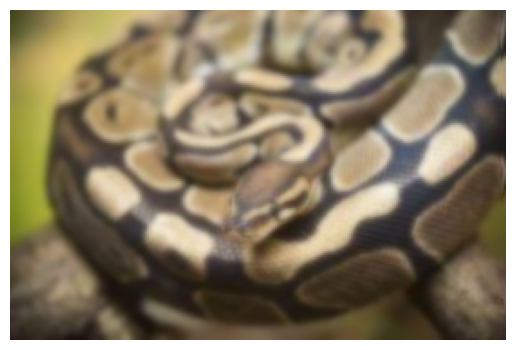

In [74]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Define a Numba CUDA kernel for Gaussian blur with shared memory
@cuda.jit
def gaussian_blur_shared(src, dst):
    tidx, tidy = cuda.grid(2)

    if tidx < src.shape[0] and tidy < src.shape[1]:
        total_weight = 0.0
        weighted_sum_r = 0.0
        weighted_sum_g = 0.0
        weighted_sum_b = 0.0
        # filter_shared = cuda.shared.array(shape=(7, 7), dtype=numba.float32)  # Define shared memory for the filter
        # tidx_s = cuda.threadIdx.x
        # tidy_s = cuda.threadIdx.y
        # filter_shared[tidx_s, tidy_s] = filter[tidx_s, tidy_s]
        # cuda.syncthreads()  # Synchronize threads to ensure filter is loaded
        # cuda.shared.array((cuda.blockDim.x, cuda.blockDim.y),numba.uint8)
        tile = cuda.shared.array((7, 7), numba.uint8)  # Define the shared memory for the filter
        # the error was due to np.type here
        # tidx_s = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
        # tidy_s = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
        # tile[cuda.threadIdx.x, cuda.threadIdx.y] = filter[tidx_s, tidy_s]
        tile[cuda.threadIdx.x, cuda.threadIdx.y] = gaussian_filter[cuda.threadIdx.x, cuda.threadIdx.y]

        cuda.syncthreads()  # Synchronize threads to ensure filter is loaded

        for i in range(-3, 4):
            for j in range(-3, 4):
                if (tidx + i) >= 0 and (tidx + i) < src.shape[0] and (tidy + j) >= 0 and (tidy + j) < src.shape[1]:
                    pixel_r = src[tidx + i, tidy + j, 0]
                    pixel_g = src[tidx + i, tidy + j, 1]
                    pixel_b = src[tidx + i, tidy + j, 2]
                    weight = tile[i + 3, j + 3]
                    weighted_sum_r += pixel_r * weight
                    weighted_sum_g += pixel_g * weight
                    weighted_sum_b += pixel_b * weight
                    total_weight += weight
        dst[tidx, tidy, 0] = np.uint8(weighted_sum_r / total_weight)
        dst[tidx, tidy, 1] = np.uint8(weighted_sum_g / total_weight)
        dst[tidx, tidy, 2] = np.uint8(weighted_sum_b / total_weight)

# Define a 7x7 Gaussian filter
gaussian_filter = np.array([
    [1, 1, 2, 2, 2, 1, 1],
    [1, 2, 2, 4, 2, 2, 1],
    [2, 2, 4, 8, 4, 2, 2],
    [2, 4, 8, 16, 8, 4, 2],
    [2, 2, 4, 8, 4, 2, 2],
    [1, 2, 2, 4, 2, 2, 1],
    [1, 1, 2, 2, 2, 1, 1]
], dtype=np.float32)

# Load an RGB image
rgb_image = imread('python.jpg')

# Get the image dimensions
imageWidth, imageHeight = rgb_image.shape[0], rgb_image.shape[1]

# Create a grid and block configuration
blockDim = (16, 16)
gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

devSrc = cuda.to_device(rgb_image)
devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

# Launch the kernel with the 2D grid and block configuration
# gaussian_blur_shared[gridDim, blockDim](devSrc, devDst, gaussian_filter)
gaussian_blur_shared[gridDim, blockDim](devSrc, devDst)
hostDst = devDst.copy_to_host()

new_image = hostDst.reshape(imageWidth, imageHeight, 3)

plt.imshow(new_image)
plt.axis('off')
plt.show()


In [75]:
# time_shared

In [76]:
import time
block_shared = [(2,2), (2,2), (4,4), (8,8), (16,16), (32, 32)]
time_shared = []

for b in block_shared:

  start_time_gpu = time.time()
  blockDim = b
  gridDim = ((imageWidth // blockDim[0]) + 1, (imageHeight // blockDim[1]) + 1)

  devSrc = cuda.to_device(rgb_image)
  devDst = cuda.device_array((imageWidth, imageHeight, 3), np.uint8)

  # Launch the kernel with the 2D grid and block configuration
  # gaussian_blur_shared[gridDim, blockDim](devSrc, devDst, gaussian_filter)
  gaussian_blur_shared[gridDim, blockDim](devSrc, devDst)
  hostDst = devDst.copy_to_host()

  new_image = hostDst.reshape(imageWidth, imageHeight, 3)
  gpu_time = time.time() - start_time_gpu
  time_shared.append(gpu_time)

block_shared1 = [2, 4, 8, 16, 32]

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 54 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [82]:
np.average(time_shared[1:])

0.003748035430908203

In [78]:
time_shared

[0.0053768157958984375,
 0.00524449348449707,
 0.002262115478515625,
 0.0020999908447265625,
 0.006495475769042969,
 0.002638101577758789]

In [79]:
# plt.plot(block_shared1, time_shared)
# plt.xticks(block_shared1)
# plt.show()

In [ ]:
import numpy as np
from numba import cuda, int32

@cuda.jit()
def add(output):
    sharedMemT = cuda.shared.array(shape=(1), dtype=int32)
    pos = cuda.grid(1)
    if pos == 0:
        sharedMemT[0] = 0

    cuda.syncthreads()

    cuda.atomic.add(sharedMemT, 0, 1)
    cuda.syncthreads()

    if pos == 0:
        output[0] = sharedMemT[0]

out = np.array([0])
add[1, 2](out)
print(out)

# CPU task

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread('python.jpg')
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

start_time = time.time()

# convert image to grayscale
gray_img = (red + green + blue)/3

cpu_time = time.time() - start_time

plt.imshow(gray_img, cmap=plt.get_cmap("gray"))
plt.axis('off')
plt.show()

In [ ]:
cpu_time